In [50]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
# Afficher toutes les lignes du résultat
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [51]:
def maximimsation_marge(montant,status):
    taux_marge = 0.05
    if status == "TP":
        res = 0 # le fraudeur est détecté
    elif status == "TN":
        res = taux_marge * montant # un client honnête est accepté
    elif status == "FP":
        res = 0.7*taux_marge * montant # un client honnête est bloqué     
    elif status == "FN": # un fraudeur est accepté 
        if montant <= 20:
            res = 0
        elif montant <= 50:
            res = -0.2 * montant
        elif montant <= 100:
            res = -0.3 * montant
        elif montant <= 200:
            res = -0.5 * montant
        else:
            res = -0.8 * montant
    return res

In [52]:
def application_regles(y_test,y_pred):
    df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'status': "null"})
    for index, row in df.iterrows():
        if row['y_test'] == 1 and row['y_pred'] == 1:
            df.at[index, 'status'] = "TP"
        elif row['y_test'] == 0 and row['y_pred'] == 0:
            df.at[index, 'status'] = "TN"
        elif row['y_test'] == 0 and row['y_pred'] == 1:
            df.at[index, 'status'] = "FP"
        elif row['y_test'] == 1 and row['y_pred'] == 0:
            df.at[index, 'status'] = "FN"
    return df

In [53]:
methods = ["smote","undersampling"]

method = "undersampling"

df_train = pd.read_csv("../data/classif/"+method+"/dataframe_train.csv")
print(df_train.shape)


df_test = pd.read_csv("../data/classif/"+method+"/dataframe_test.csv")
print(df_test.shape)

(101495, 23)
(747411, 23)


In [54]:
df_train.head()

,Montant,CodeDecision,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Heure,Jour,Mois,FlagImpaye,Cluster_Code_Decision
0,60.92,1,0,0,0,545.0,0.006986,11.305842,0.001252,50.500371,43.444766,0,1,4.0,4.0,4.0,60.92,0.0,38669,4,5,0,0
1,76.14,0,1,1,1,1.0,3.807000,-1.492390,0.863439,20.270270,33.024087,0,1,5.0,5.0,5.0,76.14,0.0,66509,17,5,0,0
2,50.99,1,0,0,0,547.0,0.000000,0.000000,0.000000,39.789501,33.546107,0,1,4.0,4.0,4.0,50.99,0.0,35585,18,3,0,0
3,70.13,0,1,1,1,1.0,0.000000,0.000000,0.000000,33.596564,33.546107,0,1,5.0,5.0,5.0,70.13,0.0,60571,8,4,0,0
4,70.13,0,1,1,1,1.0,0.000000,0.000000,0.000000,33.596564,33.546107,0,1,5.0,5.0,5.0,70.13,0.0,60571,8,4,0,0


In [55]:
col_to_drop = ["CodeDecision"]

df_train = df_train.drop(columns=col_to_drop)
df_test = df_test.drop(columns=col_to_drop)

df_train = df_train.sample(n=1000, random_state=42)
df_test = df_test.sample(n=3, random_state=42)

In [56]:
df_train.corr()

,Montant,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Heure,Jour,Mois,FlagImpaye,Cluster_Code_Decision
Montant,1.000000,0.504244,0.491667,0.464812,-0.136891,0.419109,-0.151724,0.246132,0.147357,0.067045,0.019245,0.041459,-0.093346,-0.001146,0.050169,0.914428,0.219632,0.113125,-0.057651,0.074737,0.440581,0.019229
VerifianceCPT1,0.504244,1.000000,0.949005,0.898450,-0.239954,0.243682,-0.191210,0.164264,0.120896,0.099135,-0.016498,0.179913,-0.115561,0.003231,0.130846,0.546249,0.315997,0.139263,-0.032349,0.050076,0.344746,-0.016513
VerifianceCPT2,0.491667,0.949005,1.000000,0.955407,-0.235064,0.288466,-0.205419,0.195210,0.153389,0.116000,-0.015703,0.192708,-0.146400,-0.007357,0.112104,0.563179,0.381766,0.131193,-0.023346,0.062042,0.353266,-0.015719
VerifianceCPT3,0.464812,0.898450,0.955407,1.000000,-0.224293,0.266456,-0.211352,0.173127,0.153539,0.133515,-0.014901,0.190262,-0.147085,-0.007923,0.094026,0.535313,0.367889,0.113555,-0.005992,0.045112,0.351887,-0.014919
D2CB,-0.136891,-0.239954,-0.235064,-0.224293,1.000000,-0.279910,0.210521,-0.458433,-0.024863,0.020292,0.037476,-0.041696,-0.381096,-0.688389,-0.789091,-0.135283,-0.054425,-0.213561,-0.002565,-0.201453,-0.093990,0.037481
ScoringFP1,0.419109,0.243682,0.288466,0.266456,-0.279910,1.000000,-0.115858,0.678539,0.178904,0.074699,-0.009108,0.023029,0.072951,0.219135,0.308265,0.403131,0.139982,0.070043,0.017681,0.101627,0.163584,-0.009114
ScoringFP2,-0.151724,-0.191210,-0.205419,-0.211352,0.210521,-0.115858,1.000000,-0.181566,-0.113551,-0.082701,-0.026855,-0.102548,0.055690,-0.084536,-0.102062,-0.168449,-0.104931,-0.124590,-0.029077,-0.080645,-0.266633,-0.026845
ScoringFP3,0.246132,0.164264,0.195210,0.173127,-0.458433,0.678539,-0.181566,1.000000,0.073498,0.040600,-0.014881,0.020527,0.196866,0.404911,0.525894,0.252591,0.120393,0.105897,0.041216,0.117911,0.065384,-0.014883
TauxImpNb_RB,0.147357,0.120896,0.153389,0.153539,-0.024863,0.178904,-0.113551,0.073498,1.000000,0.443158,0.009972,0.100410,-0.147982,-0.038563,-0.022332,0.175497,0.130587,0.063873,-0.040549,0.025904,0.345752,0.009968
TauxImpNB_CPM,0.067045,0.099135,0.116000,0.133515,0.020292,0.074699,-0.082701,0.040600,0.443158,1.000000,0.032091,-0.015243,-0.065572,-0.028715,-0.002801,0.090484,0.085049,0.042751,0.004897,0.007343,0.196874,0.032092


In [57]:
target = 'FlagImpaye'
predictors = ['Montant', 'VerifianceCPT1', 'VerifianceCPT2', 'VerifianceCPT3', 'D2CB', 'ScoringFP1', 'TauxImpNb_RB', 'EcartNumCheq', 'NbrMagasin3J', 'DiffDateTr1', 'DiffDateTr2',
        'DiffDateTr3', 'CA3TRetMtt', 'CA3TR', 'Heure', 'Jour', 'Mois', 'Cluster_Code_Decision']

In [58]:
import xgboost as xgb

# Create an XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', max_depth=3, learning_rate=0.01, n_estimators=100)

# Train the model
xgb_model.fit(df_train[predictors], df_train[target].values)

# Make predictions on the test set
y_pred = xgb_model.predict(df_test[predictors])

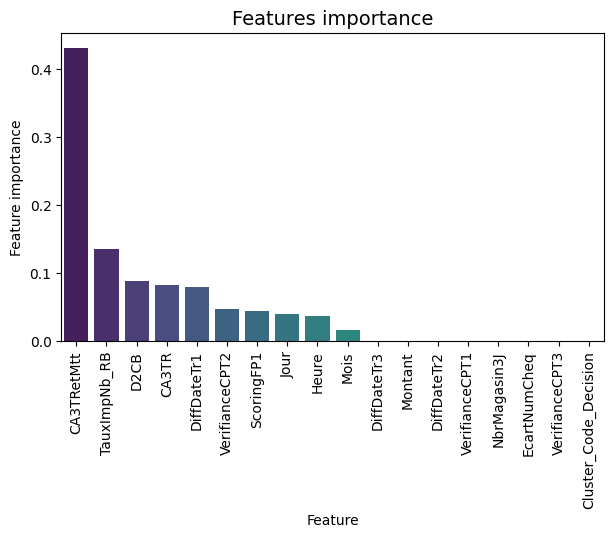

In [59]:
### Feature Importance 

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': xgb_model.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp,palette = 'viridis')
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(df_test[target] , y_pred)
precision = precision_score(df_test[target] , y_pred)
recall = recall_score(df_test[target] , y_pred)
f1 = f1_score(df_test[target], y_pred)

new_row = {'accuracy':accuracy , 'precision':precision,'recall':recall ,'f1': f1}
print(new_row)

{'accuracy': 0.6666666666666666, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}


<Figure size 1000x500 with 0 Axes>

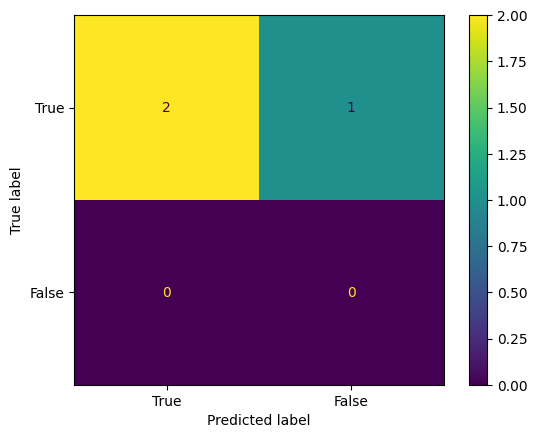

In [61]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


conf_mat = confusion_matrix(df_test[target], y_pred)
disp = ConfusionMatrixDisplay(conf_mat,display_labels = [True,False])
plt.figure(figsize = (10,5))
disp.plot()
plt.show()

# INITIALISATION SCORER

In [62]:
# Définition du scorer

def scorer_marge(y_true, y_pred, X_train):
    df_res = application_regles(y_true, y_pred)
    total_marge = 0
    
    for row in df_res.itertuples():
        montant = X_train.at[row.Index, 'Montant']  # Accéder au montant pour chaque ligne
        total_marge += maximimsation_marge(montant, row.status)
    
    return total_marge

# INITIALISATION CLASSIFIERS

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


class_weights = {0: 1.0, 1: 10.0}  

models = {

    # Mettre le class_weight ??? class_weight=class_weight 
        
    'Decision_Tree': DecisionTreeClassifier(random_state=42,class_weight=class_weights),
    'Random_Forest': RandomForestClassifier(criterion="gini",class_weight=class_weights,random_state=42)
    #'xgb_model': xgb.XGBClassifier(objective='binary:logistic', max_depth=3, learning_rate=0.01, n_estimators=100),
    #'Gradient_Boosting': GradientBoostingClassifier(random_state=42),
    #'K_Nearest_Neighbors': KNeighborsClassifier(),
    #'Support_Vector_Machine': SVC(random_state=42),
    #'Neural_Network': MLPClassifier(random_state=42),
    #'Linear_Discriminant_Analysis': LinearDiscriminantAnalysis(),
    #'Logistic_Regression': LogisticRegression(random_state=42)
}

methods = ["smote","undersampling"]

# TRAINNING : GRID SEARCH - OPTIMISATION MARGE

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score 
from sklearn.model_selection import TimeSeriesSplit
import pickle




for m in methods:
    df_train = pd.read_csv("../data/classif/"+m+"/dataframe_train.csv")
    df_train = df_train.sample(n=1000, random_state=42)# test

    X_train = df_train.drop(columns=["FlagImpaye","CodeDecision"])
    
    y_train = df_train["FlagImpaye"]

    # Boucle sur chaque modèle
    for model_name, model in models.items():
        print(f"\nTraining {model_name} for method {m}...")

        # Définir le classificateur
        clf = model

        # Définir les paramètres que vous souhaitez tester dans la recherche de grille
        param_grid = {}

        # Ajouter des paramètres spécifiques pour chaque modèle
        if model_name == 'Decision_Tree':
            param_grid = {'max_depth': [None, 10, 20],
                          'min_samples_leaf': [10, 15, 20, 25, 40]}
        elif model_name == 'Random_Forest':
            param_grid = {'n_estimators': [3, 5, 10, 50, 100],
                          'max_depth': [None, 10, 20],
                          'min_samples_leaf': [10, 15, 20, 25, 40]}
        elif model_name == 'xgb_model':
            param_grid = {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7],
                'subsample': [0.8, 1.0],
                'colsample_bytree': [0.8, 1.0],
                'gamma': [0, 0.1, 0.2],
                'min_child_weight': [1, 5, 10]
            }
        elif model_name == 'Gradient_Boosting':
            param_grid = {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7],
                'subsample': [0.8, 1.0],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': [None, 'sqrt', 'log2']
            }
        elif model_name == 'K_Nearest_Neighbors':
            param_grid = {
                'n_neighbors': [3, 5, 7, 10],
                'weights': ['uniform', 'distance'],
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                'leaf_size': [20, 30, 40],
                'p': [1, 2]
            }
        elif model_name == 'Support_Vector_Machine':
            param_grid = {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                'degree': [2, 3, 4],
                'gamma': ['scale', 'auto'],
                'class_weight': [None, 'balanced']
            }
        elif model_name == 'Neural_Network':
            param_grid = {
                'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
                'activation': ['relu', 'tanh', 'logistic'],
                'solver': ['sgd', 'adam'],
                'alpha': [0.0001, 0.001, 0.01],
                'learning_rate': ['constant', 'invscaling', 'adaptive'],
                'max_iter': [100, 200, 300],
                'early_stopping': [True, False],
                'random_state': [42]
            }
        elif model_name == 'Linear_Discriminant_Analysis':
            param_grid = {
            'solver': ['svd', 'lsqr', 'eigen'],
            'shrinkage': [None, 'auto', 0.1, 0.5, 1.0],
            'n_components': [None, 1, 2, 3]
        }
        elif model_name == 'Logistic_Regression':
            param_grid = {
            'penalty': ['l1', 'l2'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'fit_intercept': [True, False],
            'class_weight': [None, 'balanced'],
            'solver': ['liblinear', 'saga'],
            'max_iter': [100, 200, 300]
        }
  

        scorer = make_scorer(scorer_marge, X_train=X_train ,greater_is_better = True)

        # Utiliser TimeSeriesSplit pour la validation croisée
        #tscv = TimeSeriesSplit(n_splits=3)

        # Créer la grille de recherche avec votre fonction personnalisée comme mesure d'évaluation
        grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scorer, cv=3, n_jobs=-1)

        # Effectuer la recherche de grille
        grid_search.fit(X_train, y_train)

        # Afficher les résultats
        print(f"\n Best parameters for {model_name}: ", grid_search.best_params_)
        print(f"Meilleure marge pour {model_name}: ", grid_search.best_score_)

        # Sauvegarder le meilleur modèle si nécessaire
        best_model = grid_search.best_estimator_
        filename = '../models/'+m+"/"+ model_name + '.pkl'
        pickle.dump(best_model, open(filename, "wb"))


Training Decision_Tree for method smote...

 Best parameters for Decision_Tree:  {'max_depth': None, 'min_samples_leaf': 40}
Meilleure marge pour Decision_Tree:  575.9373503512576

Training Random_Forest for method smote...

 Best parameters for Random_Forest:  {'max_depth': None, 'min_samples_leaf': 40, 'n_estimators': 100}
Meilleure marge pour Random_Forest:  591.6611359042307

Training Decision_Tree for method undersampling...

 Best parameters for Decision_Tree:  {'max_depth': None, 'min_samples_leaf': 40}
Meilleure marge pour Decision_Tree:  342.9333333333332

Training Random_Forest for method undersampling...

 Best parameters for Random_Forest:  {'max_depth': None, 'min_samples_leaf': 40, 'n_estimators': 100}
Meilleure marge pour Random_Forest:  408.6207666666666


# LOAD MODELS

In [65]:
f1_df = pd.DataFrame(index=methods, columns=models.keys())
marge_df = pd.DataFrame(index=methods, columns=models.keys())

loaded_models = {}
for m in methods:
    loaded_models[m] = {}
    for model_name in models.keys():
        filename = '../models/'+m+"/"+ model_name + '.pkl'
        with open(filename, 'rb') as file:
            loaded_models[m][model_name] = pickle.load(file)

# PREDICTING LOADED MODELS


 F1 score de  Decision_Tree  sur l'ensemble de test : 0.013136288998357962
 Marge de  Decision_Tree  sur l'ensemble de test : 7166.2682
[[1790 1183]
 [  19    8]]


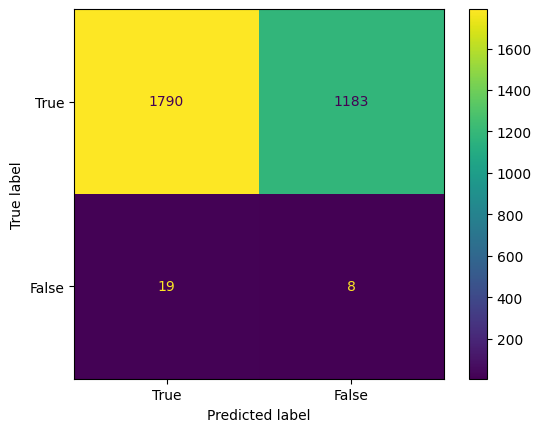


 F1 score de  Random_Forest  sur l'ensemble de test : 0.021248339973439577
 Marge de  Random_Forest  sur l'ensemble de test : 7845.4936
[[2255  718]
 [  19    8]]


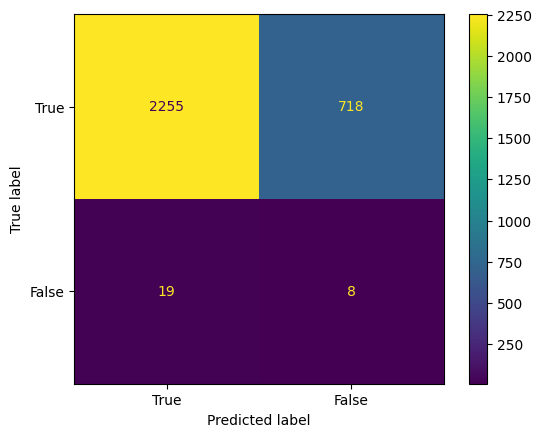

 Marge du modèle PARFAIT sur l'ensemble de test : 9259.8825

 F1 score de  Decision_Tree  sur l'ensemble de test : 0.02156586966713549
 Marge de  Decision_Tree  sur l'ensemble de test : 6878.094149999999
[[ 890 2083]
 [   4   23]]


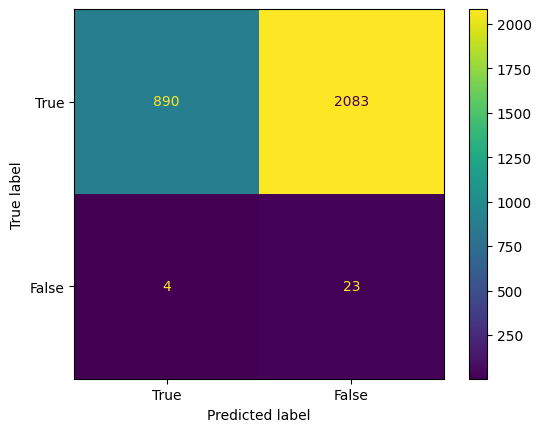


 F1 score de  Random_Forest  sur l'ensemble de test : 0.021052631578947368
 Marge de  Random_Forest  sur l'ensemble de test : 6732.974749999999
[[ 556 2417]
 [   1   26]]


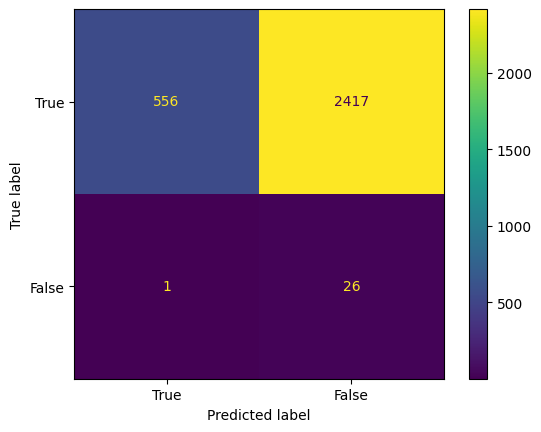

 Marge du modèle PARFAIT sur l'ensemble de test : 9259.8825


In [73]:
from sklearn.metrics import ConfusionMatrixDisplay

for m in methods:
    df_test = pd.read_csv("../data/classif/"+m+"/dataframe_test.csv")
    df_test = df_test.sample(n=3000, random_state=42) # test
    X_test = df_test.drop(columns=["FlagImpaye","CodeDecision"])
    y_test = df_test["FlagImpaye"]

    for model_name, model in loaded_models.get(m, {}).items():
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        f1_df.loc[m, model_name] = f1


        df_res = application_regles(y_test,y_pred)
        for row in df_res.itertuples():
            df_res.at[row.Index, 'marge'] = maximimsation_marge(X_test.at[row.Index, 'Montant'],row.status)

    
        total_marge = df_res['marge'].sum()
        marge_df.at[m  , model_name] = total_marge

        print("\n F1 score de ",model_name," sur l'ensemble de test :", f1)
        print(" Marge de ",model_name," sur l'ensemble de test :", total_marge)
        conf_matrix = confusion_matrix(y_test, y_pred)
        print(conf_matrix)

        disp = ConfusionMatrixDisplay(conf_matrix, display_labels=[True, False])
        disp.plot()
        plt.show()



    
    # Ajouter la marge parfaite au fichier de résultats 
    df_res = application_regles(y_test,y_test)
    for row in df_res.itertuples():
        df_res.at[row.Index, 'marge'] = maximimsation_marge(X_test.at[row.Index, 'Montant'],row.status)

    total_marge = df_res['marge'].sum()
    marge_df.at[m ,"!_Modele_Parfait_!"] = total_marge
    print(" Marge du modèle PARFAIT sur l'ensemble de test :", total_marge)

# Marge 

In [67]:
marge_df.to_csv('../data/marge.csv')
marge_df.head()

,Decision_Tree,Random_Forest,!_Modele_Parfait_!
smote,NaN,NaN,9259.8825
undersampling,6878.09415,6732.97475,9259.8825


# F1 Score

In [68]:
f1_df.to_csv('../data/f1_score.csv')
f1_df.head()

,Decision_Tree,Random_Forest
smote,0.013136,0.021248
undersampling,0.021566,0.021053


In [69]:
df_train["FlagImpaye"].value_counts()

FlagImpaye
0    772
1    228
Name: count, dtype: int64

In [70]:
df_test["FlagImpaye"].value_counts()

FlagImpaye
0    2973
1      27
Name: count, dtype: int64

In [71]:
# optimisation de la marge
#  donner la marge maximale (si modèle hypothétiquement parfait) et comparer avec la meilleure marge obtenue, du genre 'on a perdu 10% de marge par rapport au modèle parfait'

# faire ligne SMOTE 40% et 60% et comparer les résultats etc...
# faire ligne UNDERSAMPLING 40% et 60% et comparer les résultats etc....